In [4]:
import pandas as pd
import numpy as np
from ast import literal_eval

In [25]:
df = pd.read_csv('recipes_w_search_terms.csv')

In [27]:
# Preprocess list values
df["ingredients"] = df["ingredients"].apply(literal_eval)
df["steps"] = df["steps"].apply(literal_eval)
df["tags"] = df["tags"].apply(literal_eval)
df["search_terms"] = df["search_terms"].apply(literal_eval)

In [28]:
def categorize_mealtimes(terms):
    for meal in ['breakfast', 'lunch', 'dinner', 'dessert', "side"]:
        if meal in terms: return meal
    return 'other'

In [29]:
df["meal"] = df["search_terms"].apply(categorize_mealtimes)
df["meal"] = pd.Categorical(df["meal"])

In [30]:
df_labeled = df[df["meal"] != "other"]
df_unlabled = df[df["meal"] == "other"]

In [31]:
df_unlabled.shape

(108610, 11)

In [40]:
meals = ['breakfast', 'lunch', 'dinner', 'dessert', "side", "other"]
totals = [df[df['meal'] == meal].shape[0] for meal in meals]

Text(0.5, 1.0, 'Amount of Recipes by Meal')

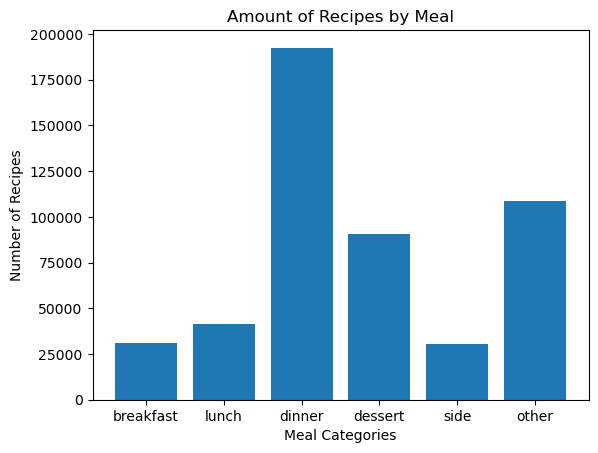

In [42]:
plt.bar(meals, totals)
plt.xlabel('Meal Categories')
plt.ylabel('Number of Recipes')
plt.title('Amount of Recipes by Meal')

In [45]:
{meals[i]: totals[i] / sum(totals[:-1]) for i in range(5)}

{'breakfast': 0.0807499877055439,
 'lunch': 0.10766837581175764,
 'dinner': 0.4982671287656625,
 'dessert': 0.2346662249290157,
 'side': 0.07864828278802029}

In [16]:
from sklearn.model_selection import train_test_split

ingredients = df_labeled["ingredients"].apply('\t'.join).apply(lambda x: x.replace(" ", "_"))

raw_train, raw_test, y_train, y_test = train_test_split(ingredients, df_labeled["meal"], test_size=.2)

## Ridge Classification

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()#min_df = 3, max_df = 0.4, ngram_range = (1, 2))
X_train = vectorizer.fit_transform(raw_train)
X_test = vectorizer.transform(raw_test)
feature_names = vectorizer.get_feature_names_out()

In [ ]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [49]:
test_accuracy = clf.score(X_test, y_test)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy on test set: 0.733


In [12]:
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import RidgeClassifier
# from sklearn.feature_extraction.text import CountVectorizer


# pipe = Pipeline([
#     ("vectorizer", CountVectorizer()),
#     ("classifier", RidgeClassifier(tol=1e-2, solver="sparse_cg"))
# ])

# pipe

In [ ]:
# pipe.fit(X_test, y_test)

# pred = pipe.predict(X_test)

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

def confusion_matrix(predictions):
    fig, ax = plt.subplots(figsize=(10, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, predictions, ax=ax)

confusion_matrix(pred)

In [18]:
target_names = ['breakfast', 'dessert', 'dinner', 'lunch', "side"]

top 5 keywords per class:
       breakfast          dessert                             dinner  \
0           eggs            sugar                        ground_beef   
1           milk          vanilla                              onion   
2            egg            flour  boneless_skinless_chicken_breasts   
3  baking_powder  vanilla_extract                      garlic_cloves   
4            all    purpose_flour                    chicken_breasts   

             lunch       side  
0       mayonnaise       salt  
1              all     butter  
2            bread  olive_oil  
3  flour_tortillas   potatoes  
4    baking_powder     pepper  


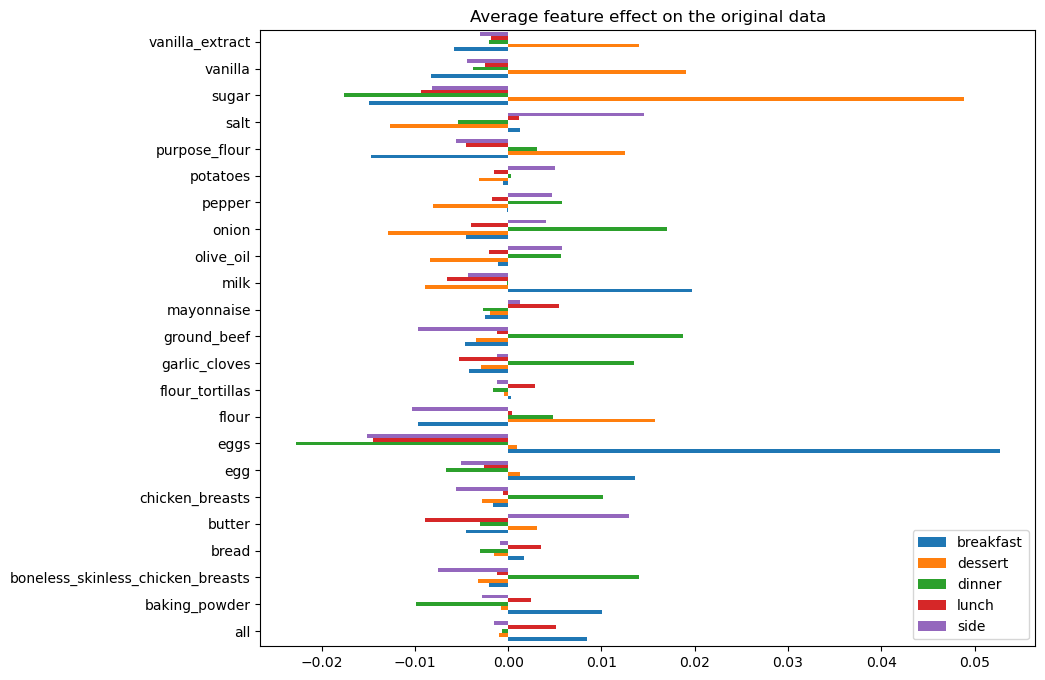

In [53]:
import numpy as np
import pandas as pd


def plot_feature_effects(model):
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = model.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)

    return ax


_ = plot_feature_effects(clf).set_title("Average feature effect on the original data")

## Naive Bayes

In [17]:
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("naive_bayes", ComplementNB())
])

pipe

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('naive_bayes', ComplementNB())])

In [18]:
parameter_grid = {
    "vectorizer__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vectorizer__min_df": (1, 3, 5, 10),
    "vectorizer__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "naive_bayes__alpha": np.logspace(-6, 6, 13),
}

In [19]:
from pprint import pprint

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=parameter_grid,
    n_iter=40,
    random_state=0,
    n_jobs=20,
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'naive_bayes__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
 'vectorizer__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
 'vectorizer__min_df': (1, 3, 5, 10),
 'vectorizer__ngram_range': ((1, 1), (1, 2))}


In [ ]:
random_search.fit(raw_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                             ('naive_bayes', ComplementNB())]),
                   n_iter=40, n_jobs=20,
                   param_distributions={'naive_bayes__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
                                        'vectorizer__max_df': (0.2, 0.4, 0.6,
                                                               0.8, 1.0),
                                        'vectorizer__min_df': (1, 3, 5, 10),
                                        'vectorizer__ngram_range': ((1, 1),
                                                                    (1, 2))},
                   random_state=0, verbose=1)

In [21]:
random_search.best_params_

{'vectorizer__ngram_range': (1, 2),
 'vectorizer__min_df': 3,
 'vectorizer__max_df': 0.4,
 'naive_bayes__alpha': np.float64(0.01)}

In [ ]:
test_accuracy = random_search.score(raw_test, y_test)
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.701
Accuracy on test set: 0.705


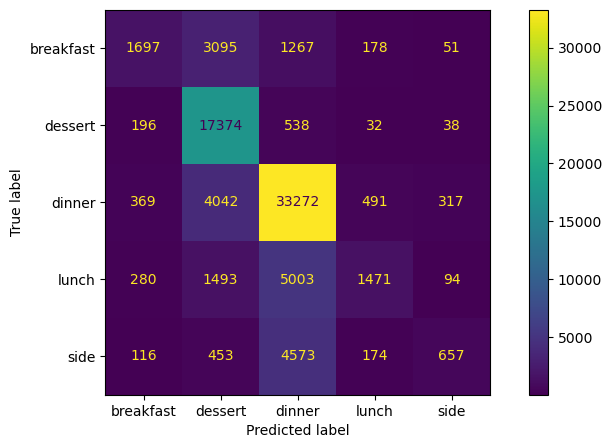

In [23]:
confusion_matrix(random_search.predict(X_test))

## Random Forest Model

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("vectorizer", CountVectorizer(
        min_df = 3,
        max_df = 0.4,
        ngram_range = (1, 2)
    )),
    ("classifier", RandomForestClassifier())
])

pipe

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.4, min_df=3, ngram_range=(1, 2))),
                ('classifier', RandomForestClassifier())])

In [25]:
parameter_grid = { 
    "classifier__n_estimators": (10, 50, 100, 200),
    "classifier__criterion": ("gini", "entropy", "log_loss"),
    "classifier__max_depth": (2, 3, 4) 
}

In [26]:
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=parameter_grid,
    n_iter=40,
    random_state=0,
    n_jobs=20,
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'classifier__criterion': ('gini', 'entropy', 'log_loss'),
 'classifier__max_depth': (2, 3, 4),
 'classifier__n_estimators': (10, 50, 100, 200)}


In [ ]:
random_search.fit(raw_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=40. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=Pipeline(steps=[('vectorizer',
                                              CountVectorizer(max_df=0.4,
                                                              min_df=3,
                                                              ngram_range=(1,
                                                                           2))),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_iter=40, n_jobs=20,
                   param_distributions={'classifier__criterion': ('gini',
                                                                  'entropy',
                                                                  'log_loss'),
                                        'classifier__max_depth': (2, 3, 4),
                                        'classifier__n_estimators': (10, 50,
                                                                     100,
                                                                     200)},
                   random_state=0, verbose=1)

In [ ]:
test_accuracy = random_search.score(raw_test, y_test)
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.509
Accuracy on test set: 0.500


## SVM

In [48]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

pipe = Pipeline([
    ("vectorizer", CountVectorizer(
        min_df = 3,
        max_df = 0.4,
        ngram_range = (1, 2)
    )),
    ("classifier", LinearSVC(C=0.1, dual=False, max_iter=1000))
])

pipe

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.4, min_df=3, ngram_range=(1, 2))),
                ('classifier', LinearSVC(C=0.1, dual=False))])

In [54]:
pipe.fit(raw_train, y_train)
test_accuracy = pipe.score(raw_test, y_test)

In [55]:
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy on test set: 0.733


In [ ]:
predictions = pipe.predict(raw_test)
for i, (input, prediction, label) in enumerate(zip(raw_test, predictions, y_test)):
    if prediction != label:
        print(, 'has been classified as ', prediction, 'and should be ', label)

frozen_pink_lemonade_concentrate	cool_whip	eagle_brand_condensed_milk	graham_cracker_pie_crusts has been classified as  dessert and should be  lunch
olive_oil	ground_beef	mushrooms	onions	garlic_cloves	tomato_paste	dried_oregano	ground_cinnamon	parmesan_cheese	parsley	eggs	salt_and_pepper	phyllo_pastry has been classified as  dinner and should be  lunch
eggs	canned_pumpkin	milk	half-and-half	granulated_sugar	ground_cinnamon	salt	ground_nutmeg	vanilla_extract	french_bread	pecans	light_brown_sugar	butter	light_corn_syrup	vanilla_extract has been classified as  breakfast and should be  dessert
extra_virgin_olive_oil	onion	lean_ground_beef	ketchup	chili_powder	prepared_yellow_mustard	salt	fresh_ground_black_pepper has been classified as  dinner and should be  lunch
romaine_lettuce	frozen_peas	celery	scallions	dried_dill_weed	salt	fresh_ground_black_pepper	miracle_whip	tomatoes	salt has been classified as  side and should be  dinner
black-eyed_peas	yellow_onion	egg	salt	fresh_ground_black_p

id                                      name  \
0        96313               Grilled Garlic Cheese Grits   
1       232037     Simple Shrimp and Andouille Jambalaya   
2        41090                black-and-white bean salad   
3        60656                Crock Pot Italian Zucchini   
4       232047             Beef Stew With Dried Cherries   
...        ...                                       ...   
494958  276465                  Blackberry Orange Scones   
494959  257796  Slow Cooker Garlic Chicken With Rosemary   
494960   78003           Pot Roast with Port (Stove Top)   
494961  328810          Kapusta ( Cabbage and Kielbasa )   
494962    9116             Yellow or Zucchini Squash Pie   

                                              description  \
0       We love grits, this is another good way to ser...   
1       Simple, easy and very tasty for when you are i...   
2                                                     NaN   
3       This is a good recipe for weight watchers. It ...   
4       This is a fabulous stew that came from one of ...   
...                                                   ...   
494958  The orange zest makes for a flavorful, not ove...   
494959                                Delicious and easy!   
494960  This is a recipe from the Frugal Gourmet cooki...   
494961                Cabbage and sausage in tomato sauce   
494962  This recipe was given to my mom from a lady wh...   

                                              ingredients  \
0       [water, grits, salt, cheddar cheese, garlic, o...   
1       [onion, red bell pepper, garlic cloves, large ...   
2       [white beans, canned black beans, tomatoes, on...   
3       [zucchini, yellow squash, diced tomatoes, onio...   
4       [beef stew meat, flour, salt, allspice, cinnam...   
...                                                   ...   
494958  [unbleached flour, baking soda, butter, orange...   
494959  [roasting chickens, lemons, rosemary sprigs, p...   
494960  [boneless beef chuck roast, olive oil, tawny p...   
494961  [cabbage, condensed tomato soup, kielbasa, oni...   
494962  [zucchini, onion, butter, oregano, basil, salt...   

                                      ingredients_raw_str serving_size  \
0       ["4   cups    water","1   cup   uncooked old f...    1 (155 g)   
1       ["1   medium    onion, chopped coarse ","1   m...    1 (366 g)   
2       ["1   cup   canned white beans, rinsed and dra...    1 (807 g)   
3       ["2       zucchini, sliced ","2   small    yel...    1 (244 g)   
4       ["3   lbs    beef stew meat","3   tablespoons ...    1 (358 g)   
...                                                   ...          ...   
494958  ["2 1/2  cups    unbleached flour","2   teaspo...     1 (83 g)   
494959  ["1 (5   lb)    roasting chickens, rinsed and ...    1 (340 g)   
494960  ["2 -3   lbs    boneless beef chuck roast","2 ...    1 (283 g)   
494961  ["8   cups    cabbage or 2   heads    cabbage,...    1 (564 g)   
494962  ["4   cups    zucchini (can mix the squash if ...    1 (160 g)   

        servings                                              steps  \
0              8  [I a sauce pan, bring water to a boil; slowly ...   
1              4  [In a food processor, pulse the onion, red pep...   
2              1  [In a large bowl, combine beans, tomato, onion...   
3              4  [Put all ingredients in the crock pot and cook...   
4              8  [Preheat oven to 350°F., Cut beef into 1 inch ...   
...          ...                                                ...   
494958         8  [Sift about 2 cups of flour onto a piece of wa...   
494959         6  [Place rosemary springs, 1 lemon half, celery,...   
494960         4  [In a large pan, heat oil and brown roast on b...   
494961         6  [Saute bacon in large pan until browned.  Leav...   
494962         6  [Melt butter in skillet. Add squash, onions, s...   

                                                     tags  \
0       [time-to-make,

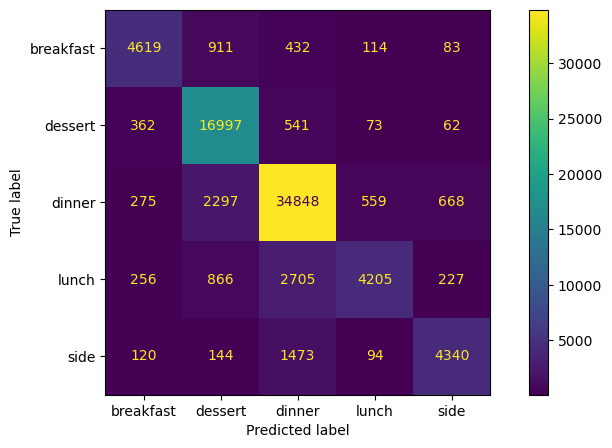

In [52]:
confusion_matrix(pipe.predict(raw_test))

In [54]:
vectorizer =  CountVectorizer(
        min_df = 3,
        max_df = 0.4,
        ngram_range = (1, 2)
    )
classifier = LinearSVC(C=0.1, dual=False, max_iter=1000)

X_train = vectorizer.fit_transform(raw_train)
X_test = vectorizer.transform(raw_test)
feature_names = vectorizer.get_feature_names_out()
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)

In [49]:
parameter_grid = {
    "vectorizer__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vectorizer__min_df": (1, 3, 5, 10),
    "vectorizer__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "classifier__C": np.logspace(.001, 1, 15),
}

In [52]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=parameter_grid,
    n_iter=40,
    random_state=0,
    n_jobs=32,
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
print(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'vectorizer__max_df': (0.2, 0.4, 0.6, 0.8, 1.0), 'vectorizer__min_df': (1, 3, 5, 10), 'vectorizer__ngram_range': ((1, 1), (1, 2)), 'classifier__C': array([ 1.00230524,  1.18129167,  1.39224057,  1.64085962,  1.93387577,
        2.2792172 ,  2.68622791,  3.16592046,  3.73127401,  4.39758544,
        5.18288328,  6.10841551,  7.19922446,  8.48482437, 10.        ])}


In [53]:
random_search.fit(raw_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


KeyboardInterrupt: 

top 5 keywords per class:
  breakfast          dessert                             dinner  \
0      eggs            sugar                              onion   
1      milk          vanilla                      garlic_cloves   
2       egg    purpose_flour                        ground_beef   
3       all  vanilla_extract  boneless_skinless_chicken_breasts   
4  cinnamon            flour                    chicken_breasts   

             lunch               side  
0       mayonnaise               salt  
1              all             butter  
2            bread           potatoes  
3  flour_tortillas  all purpose_flour  
4     cream_cheese          olive_oil  


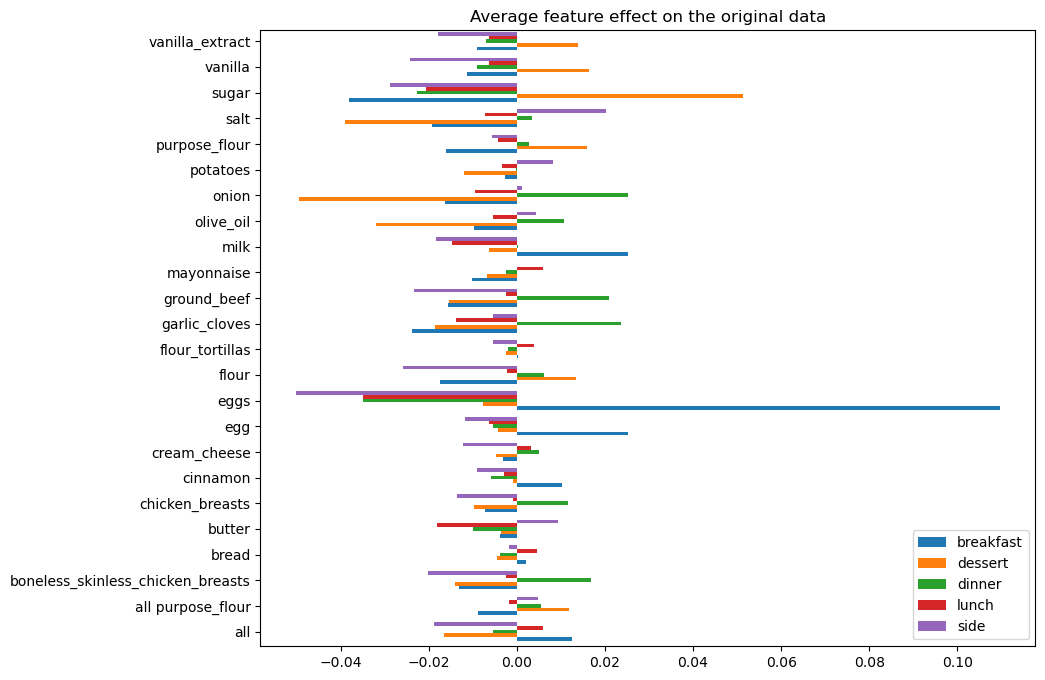

In [56]:
_ = plot_feature_effects(classifier).set_title("Average feature effect on the original data")

## Confusion matrix for ANN

In [13]:
import pandas as pd
df = pd.read_csv("ANN_predictions.csv", header=None)

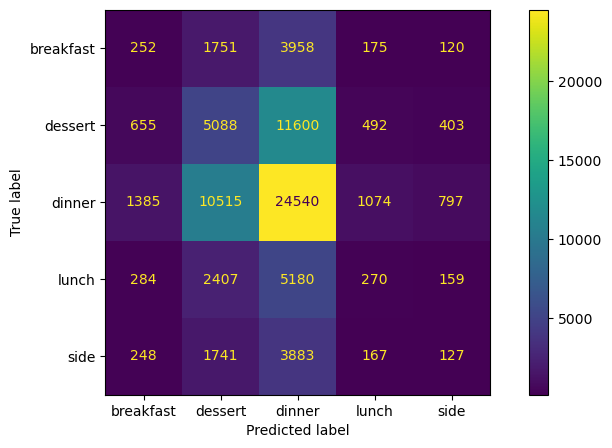

In [17]:
confusion_matrix(df[1])